# init

In [ ]:
%%file __init__.py
# %load __init__.py
#!/usr/bin/env python

# In[ ]:


import os
os.chdir('C:/Users/6506/Anaconda3/Lib/food/')


# In[ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# In[ ]:


#import data
test=pd.read_csv('C:/Users/6506/Desktop/FDA/N334/變數刪除後123/分析大表testing_data_11_flted.csv',encoding='ANSI')
train=pd.read_csv('C:/Users/6506/Desktop/FDA/N334/變數刪除後123/分析大表training_data_11_flted.csv',encoding='ANSI')
df=pd.concat([test,train])


# In[ ]:


#transform category variable type
d=df.dtypes==object
for i in d[d==True].index[1:]:
    df[i]=df[i].astype('category').cat.codes

# for i in d[d==True].index[1:]:
#     dummies=pd.get_dummies( df.loc[:, i], prefix=i)
#     df = pd.concat( [df, dummies], axis = 1 )
#     df=df.drop(i,axis=1)


# In[ ]:


#normalization
from sklearn import preprocessing
df.iloc[:,2:]=preprocessing.MinMaxScaler().fit_transform(df.iloc[:,2:])


# In[ ]:


#split data
test=df.iloc[0:len(test)]
train=df.iloc[len(test):]
y_true=test.iloc[:,1]

i_train=lambda i:train[train['檢驗不合格']==i]

#Design of Experiment
import pyDOE2
ccd=pyDOE2.ccdesign(2,center=(4,4),face='cci')
ccd=np.rint((ccd+1)*(len(i_train(0))-len(i_train(1)))/2+len(i_train(1)))
ccd=pd.DataFrame(ccd,columns=['合格','不合格'])
ccd['合格準確率']=0;ccd['不合格準確率']=0;ccd['F1 score']=0

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from . import confusion
from . import model_ 

print('Resampling:')
for i in range(len(model_.Model.samplers2)):
    print('%d. %s'%(i+1,model_.Model.samplers2[i][0]))

print('\nSelect Model:')
for i in range(len(model_.Model.classifiers)):
    print('%d. %s'%(i+1,model_.Model.classifiers[i][0]))
    
def doe_model(method,name):
    global model
    model=0
    model=model_.Model(method,name)
    global ccd
    print('--constructing',end='')
    for n in range(len(ccd)):
        p=model(ccd.iloc[n,0],ccd.iloc[n,1])
        ccd.iloc[n,2]=p[1][0]
        ccd.iloc[n,3]=p[1][1]
        ccd.iloc[n,4]=p[2][1]
        print('.',end='')
    print('\n\nResampling:',end='')
    display(ccd)
    
    from . import LinealModel
    LinealModel.opt()

def select_model(method,name):
    global model
    model=0    
    model=model_.Model(method,name)
    p=model(len(train)*0.7,len(train)*0.3)
    
    # Confusion_matrix
    print('\nConfusion_matrix:')
    confusion.Confusion_matrix(y_true, model.y_pred)
    print(classification_report(y_true, model.y_pred, target_names=['0','1']))

trained_models=[list() for x in model_.Model.classifiers]
    
def ensemble():
    global model
    result=pd.DataFrame()
    for i in range(len(model_.Model.classifiers)):
        model=model_.Model(model_.Model.samplers2[0][0],model_.Model.classifiers[i][0])
        p=model(len(train)*0.7,len(train)*0.3)
        result['R-'+model_.Model.classifiers[i][0]]=model.y_proba[:,1]
        trained_models[i].append(model.clf)
    result['R-vote']=round(result.iloc[:,0:6].mean(axis=1)).astype(int)
    
    for i in range(len(model_.Model.classifiers)):
        model=model_.Model(model_.Model.samplers2[1][0],model_.Model.classifiers[i][0])
        p=model(len(train)*0.7,len(train)*0.3)
        result['S-'+model_.Model.classifiers[i][0]]=model.y_proba[:,1]
        trained_models[i].append(model.clf)
    result['S-vote']=round(result.iloc[:,7:13].mean(axis=1)).astype(int)
    result['all-vote']=round(result.iloc[:,np.r_[0:6,7:13]].mean(axis=1)).astype(int)
#     result=pd.DataFrame(index=['1'],
#                         columns=[model_.Model.classifiers[i][0] for i in range(len(model_.Model.classifiers)),'Vote'])
    pd.set_option('display.float_format',lambda x : '%.2f' % x)
    return result
def trained_model(method,name):
    global model
    model=0    
    model=model_.Model(method,name)    
    y_pred=trained_models[model.method-1][model.name-1].predict(test.iloc[:,2:])
    # Confusion_matrix
    print('\nConfusion_matrix:')
    confusion.Confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred, target_names=['0','1']))    

# model

In [ ]:
%%file model_.py
from . import *
from . import test,train,ccd,y_true

import warnings
from sklearn.feature_selection import f_regression
#logistic,ElasticNet
from sklearn.linear_model import LogisticRegression,ElasticNet,SGDClassifier
#gradient boosting,RandomForest
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier,GradientBoostingClassifier,RandomForestClassifier
#decision tree
from sklearn import tree
#naive bayes
from sklearn.naive_bayes import GaussianNB
#pipeline
from scipy import interp
from sklearn import neighbors
from collections import Counter
from sklearn.pipeline import Pipeline
#imbalance data
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline


class Model(object):

    def ratio_multiplier(y):
        target_stats = Counter(y)
        target_stats[0]=number_m
        return target_stats
    def ratio_multiplier2(y):
        target_stats = Counter(y)
        target_stats[1]=number_n
        return target_stats

    RS=None

    samplers = [
        ['RUS', RandomUnderSampler(random_state=RS,sampling_strategy=ratio_multiplier)],
    ]

    samplers2 = [
        ['Random Over Sample', RandomOverSampler(random_state=RS,sampling_strategy=ratio_multiplier2)],
        ['SMOTE', SMOTE(random_state=RS,sampling_strategy=ratio_multiplier2)],
#         ['ADASYN', ADASYN(random_state=RS)],    
    ]

    classifiers = [
        ['Logistic',LogisticRegression(random_state=RS, solver='lbfgs',multi_class='multinomial')],
        ['Gradient',GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=RS)],
        ['Tree',tree.DecisionTreeClassifier(max_depth=10, random_state=RS)],
        ['RandomForest',RandomForestClassifier(n_estimators=100,random_state=RS)],
        ['Naive Bayes',GaussianNB()],
        ['ElasticNet',SGDClassifier(loss='modified_huber',random_state=RS)],
#         ['ElasticNet',ElasticNet(random_state=RS)],
#         ['3NN', neighbors.KNeighborsClassifier(3)],
#         ['2NN', neighbors.KNeighborsClassifier(2)],
    ]

    
    
    def __init__(self,method,name):
        for i in range(len(self.samplers2)):
            if method==i+1:
                print('--%s' %self.samplers2[i][0],end='')
            if method==self.samplers2[i][0]:
                method=i+1
                print('--%s' %self.samplers2[i][0],end='')            
        self.method=method
        
        for i in range(len(self.classifiers)):
            if name==i+1:
                print('--%s_model--' %self.classifiers[i][0]) 
            if name==self.classifiers[i][0]:
                name=i+1
                print('--%s_model--' %self.classifiers[i][0])
        self.name=name
        
        

    def __call__(self,m,n):
        global number_m
        global number_n
        m,n=int(m),int(n)
        number_m,number_n=m,n
        
        pipelines = [
        ['{}-{}-{}'.format(sampler[0],sampler2[0], classifier[0]),
         make_pipeline(sampler[1],sampler2[1], classifier[1])]
        for sampler in self.samplers for sampler2 in self.samplers2 for classifier in self.classifiers
        ]   
        
        train=pd.concat([i_train(0),i_train(1)])
                    
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")

            p=(self.method-1)*(len(self.classifiers))+self.name-1
            clf = pipelines[p][1].fit(train.iloc[:,2:], train.iloc[:,1])
            
            y_pred=clf.predict(test.iloc[:,2:])            
            p=precision_recall_fscore_support(y_true, y_pred)
                                    
            #p-value
            self.y_proba=clf.predict_proba(test.iloc[:,2:])
            self.pv=f_regression(train.iloc[:,2:], train.iloc[:,1])[1]
            self.clf=clf
            self.y_pred=y_pred
            self.train=train
        
        return p

# LinealModel

In [ ]:
%%file LinealModel.py
from . import *
from . import test,train,ccd,y_true

bounds = [(len(i_train(1)), (len(i_train(0)))), (len(i_train(1)), (len(i_train(0))))]

def opt():
    #fit
    from sklearn.linear_model import LinearRegression
    X=ccd.iloc[:,:2]
    y1=ccd.iloc[:,2]
    y2=ccd.iloc[:,3]
    
    from sklearn.preprocessing import PolynomialFeatures 

    poly = PolynomialFeatures(degree = 2) 
    X_poly = poly.fit_transform(X)

    def polyfit(y):
        poly.fit(X_poly, y) 
        l = LinearRegression().fit(X_poly, y) 
        return l
    
    l1=polyfit(y1)
    l2=polyfit(y2)
    print('y1_score:%f  y2_score:%f'%(l1.score(X_poly, y1),l2.score(X_poly, y2)))
    
    l1coef=lambda n:l1.coef_[n]
    l2coef=lambda n:l2.coef_[n]
    
    def eggholder(x):
        a=l1coef(0)+x[0]*l1coef(1)+x[1]*l1coef(2)+x[0]*x[0]*l1coef(3)+x[0]*x[1]*l1coef(4)+x[1]*x[1]*l1coef(5)
        b=l2coef(0)+x[0]*l2coef(1)+x[1]*l2coef(2)+x[0]*x[0]*l2coef(3)+x[0]*x[1]*l2coef(4)+x[1]*x[1]*l2coef(5)
        a=np.where(a>0,np.where(a>1,1,a),0);b=np.where(b>0,np.where(b>1,1,b),0);
        c=np.sqrt(a*b)
        return -c
    eggplot=lambda x:eggholder(x)*-1
    
    #3D
    from mpl_toolkits.mplot3d import Axes3D

    x = np.arange(len(i_train(1)), (len(i_train(0))),1000)
    y = np.arange(len(i_train(1)), (len(i_train(0))),1000)
    xgrid, ygrid = np.meshgrid(x, y)
    xy = np.stack([xgrid, ygrid])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(45, -45)
    ax.plot_surface(xgrid, ygrid, eggplot(xy), cmap='terrain')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('eggholder(x, y)')

    print('\nRegressionModel:',end='')
    plt.show()
    
    #opt
    from scipy import optimize
    results = dict()

#     from numpy.random import random
#     r = random(6)  # Random start vector
#     res = minimize(lambda x: np.var(x), r, bounds)

    results['min']= optimize.minimize(eggholder, bounds)
    results['shgo'] = optimize.shgo(eggholder, bounds)
    results['DA'] = optimize.dual_annealing(eggholder, bounds)
    results['DE'] = optimize.differential_evolution(eggholder, bounds)
    results['BH'] = optimize.basinhopping(eggholder, bounds)
    
    for key in results:
        if results['min']['fun']>results[key]['fun']:
            results['min']=results[key]
            
    print('Optimize:')
    print(results['min'])
    
    fy1,fy2,favg,avgpv=0,0,0,0
    for n in range(10):
        p=model(int(results['min']['x'][0]),int(results['min']['x'][1]))
        fy1+=p[1][0]*0.1
        fy2+=p[1][1]*0.1
        favg+=p[2][1]*0.1
        avgpv+=model.pv*0.1

    print('\nOptimize Resampling:')
    display(pd.DataFrame([[int(results['min']['x'][0]),int(results['min']['x'][1]),fy1,fy2,favg]]
                         ,columns=['合格','不合格','合格準確率','不合格準確率','F1 score'],index=['平均']))
# Confusion_matrix
    print('Confusion_matrix:')
    confusion.Confusion_matrix(y_true, model.y_pred)
    print(classification_report(y_true, model.y_pred, target_names=['0','1']))

# food

In [1]:
import requests
requests.__path__

['C:\\Users\\6506\\Anaconda3\\lib\\site-packages\\requests']

In [2]:
import os
os.chdir('C:/Users/6506/Anaconda3/Lib/food/')

In [3]:
import food

Resampling:
1. Random Over Sample
2. SMOTE

Select Model:
1. Logistic
2. Gradient
3. Tree
4. RandomForest
5. Naive Bayes
6. ElasticNet


--Random Over Sample--ElasticNet_model--

Confusion_matrix:
Confusion matrix, without normalization
[[1868 1894]
 [  28  176]]
Normalized confusion matrix
[[0.5  0.5 ]
 [0.14 0.86]]


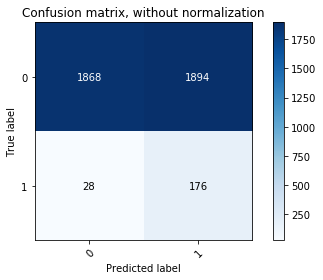

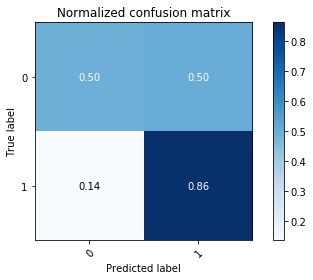

              precision    recall  f1-score   support

           0       0.99      0.50      0.66      3762
           1       0.09      0.86      0.15       204

    accuracy                           0.52      3966
   macro avg       0.54      0.68      0.41      3966
weighted avg       0.94      0.52      0.63      3966



In [4]:
food.select_model(1,6)

In [ ]:
food.doe_model(1,5)

In [ ]:
food.model.train[food.model.train.iloc[:,1]==1]

In [ ]:
from sklearn.externals.six import StringIO
import pydotplus
import graphviz
from sklearn import tree

dot_data = StringIO()
tree.export_graphviz(food.model.clf,
        out_file=dot_data,
        feature_names=food.train.iloc[:,2:].columns,
        class_names=['0','1'],
        filled=True, rounded=True,
        impurity=False)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/6506/AppData/Local/Continuum/anaconda3/Library/bin/graphviz'
graph.write_svg('C:/Users/6506/Desktop/g.svg')

In [ ]:
food.pd.set_option('display.float_format',lambda x : '%.2f' % x)
food.model.y_proba[:,1]

In [ ]:
result=food.ensemble()

In [ ]:
food.confusion.Confusion_matrix(food.y_true,result['all-vote'])
print(food.classification_report(food.y_true, result['all-vote'], target_names=['0','1']))

In [ ]:
result

In [ ]:
food.trained_model(1,1)